In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

In [26]:
df = pd.read_csv('Point_Of_Interest.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [28]:
zip_code_data = pd.read_csv('us_zip_codes')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20595 entries, 0 to 20594
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    20595 non-null  object 
 1   SEGMENTID   20595 non-null  int64  
 2   COMPLEXID   20595 non-null  int64  
 3   SAFTYPE     10393 non-null  object 
 4   SOS         20003 non-null  float64
 5   PLACEID     20595 non-null  int64  
 6   FACI_DOM    20595 non-null  int64  
 7   BIN         20595 non-null  int64  
 8   BOROUGH     20384 non-null  float64
 9   CREATED     20595 non-null  object 
 10  MODIFIED    19228 non-null  object 
 11  FACILITY_T  20595 non-null  int64  
 12  SOURCE      20595 non-null  object 
 13  B7SC        10389 non-null  float64
 14  PRI_ADD     20595 non-null  int64  
 15  NAME        20595 non-null  object 
dtypes: float64(3), int64(7), object(6)
memory usage: 2.5+ MB


In [30]:
columns_to_keep = ['FACILITY_T', 'FACI_DOM', 'BOROUGH', 'the_geom', 'NAME']
cleaned_data = df[columns_to_keep]

In [31]:
# Extract latitude and longitude from geom
cleaned_data[['LNG', 'LAT']] = cleaned_data['the_geom'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)

C:\Users\simon\AppData\Local\Temp\ipykernel_7712\628058781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[['LNG', 'LAT']] = cleaned_data['the_geom'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
C:\Users\simon\AppData\Local\Temp\ipykernel_7712\628058781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[['LNG', 'LAT']] = cleaned_data['the_geom'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)


In [32]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20595 entries, 0 to 20594
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FACILITY_T  20595 non-null  int64  
 1   FACI_DOM    20595 non-null  int64  
 2   BOROUGH     20384 non-null  float64
 3   the_geom    20595 non-null  object 
 4   NAME        20595 non-null  object 
 5   LNG         20595 non-null  float64
 6   LAT         20595 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [33]:
# Define the mapping 
facility_type_mapping = {
    2: 'Education Facility',
    3: 'Cultural Facility',
    4: 'Recreational Facility',
    6: 'Transportation Facility',
    9: 'Religious Institution',
    10: 'Health Services',
    11: 'Public Safety'
}

In [34]:
# Filter 
cleaned_data = cleaned_data[cleaned_data['FACILITY_T'].isin(facility_type_mapping.keys())]

# Map Facility 
cleaned_data['FACILITY_T'] = cleaned_data['FACILITY_T'].map(facility_type_mapping)


In [35]:
# Convert borough to names
borough_mapping = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

cleaned_data['BOROUGH'] = cleaned_data['BOROUGH'].map(borough_mapping)

In [36]:
# Zipcode mapping using KDTree
zip_code_tree = cKDTree(zip_code_data[['LAT', 'LNG']].values)
_, idx = zip_code_tree.query(cleaned_data[['LAT', 'LNG']].values)
cleaned_data['ZIP_CODE'] = zip_code_data['ZIP'].iloc[idx].values

In [37]:
cleaned_data

,FACILITY_T,FACI_DOM,BOROUGH,the_geom,NAME,LNG,LAT,ZIP_CODE
0,Transportation Facility,9,Manhattan,POINT (-74.00701717096757 40.724634757833414),HOLLAND,-74.007017,40.724635,10013
1,Transportation Facility,8,Queens,POINT (-73.82661642130311 40.797182526598505),WHITESTONE,-73.826616,40.797183,11351
2,Transportation Facility,8,Brooklyn,POINT (-73.99395441100663 40.70384707235758),BROOKLYN,-73.993954,40.703847,10038
3,Transportation Facility,8,Manhattan,POINT (-73.9919414213091 40.70960010711745),MANHATTAN,-73.991941,40.709600,10002
4,Transportation Facility,8,Brooklyn,POINT (-73.9526609766105 40.73906602249743),PULASKI,-73.952661,40.739066,11109
...,...,...,...,...,...,...,...,...
20590,Recreational Facility,9,Brooklyn,POINT (-73.94931898144033 40.70268116179689),DE HOSTOS PLAYGROUND,-73.949319,40.702681,11206
20591,Public Safety,1,Queens,POINT (-73.73345230015069 40.66635980429733),116 PRECINCT,-73.733452,40.666360,11422
20592,Recreational Facility,12,Manhattan,POINT (-73.99939639223179 40.73450912110648),JEFFERSON MARKET GARDEN,-73.999396,40.734509,10014
20593,Recreational Facility,9,Staten Island,POINT (-74.1881919612981 40.59019555904301),SCHMUL PARK PLAYGROUND,-74.188192,40.590196,10311


In [38]:
facility_domain_mapping = {
    'Education Facility': {
        1: 'Public Elementary School', 2: 'Public Junior High-Intermediate-Middle', 3: 'Public High School',
        4: 'Private/Parochial Elementary School', 5: 'Private/Parochial Junior/Middle School', 6: 'Private/Parochial High School',
        7: 'Post Secondary Degree Granting Institution', 8: 'Other', 9: 'Public Early Childhood',
        10: 'Public K-8', 11: 'Public K-12 all grades', 12: 'Public Secondary School', 13: 'Public School Building',
        14: 'Public School Annex', 15: 'Private/Parochial Early Childhood', 16: 'Private/Parochial K-8',
        17: 'Private/Parochial K-12 all grades', 18: 'Private/Parochial Secondary School'
    },
    'Cultural Facility': {
        1: 'Center', 2: 'Library', 3: 'Theater/Concert Hall', 4: 'Museum', 5: 'Other'
    },
    'Recreational Facility': {
        1: 'Park', 2: 'Amusement Park', 3: 'Golf Course', 4: 'Beach', 5: 'Botanical Garden', 6: 'Zoo',
        7: 'Recreational Center', 8: 'Sports', 9: 'Playground', 10: 'Other', 11: 'Pool', 12: 'Garden'
    },
    'Transportation Facility': {
        1: 'Bus Terminal', 2: 'Ferry landing/terminal', 3: 'Transit/Maintenance Yard', 4: 'Airport', 5: 'Heliport',
        6: 'Marina', 7: 'Pier', 8: 'Bridge', 9: 'Tunnel', 10: 'Exit/Entrance', 11: 'Water Navigation', 12: 'Other'
    },
    'Religious Institution': {
        1: 'Church', 2: 'Synagogue', 3: 'Temple', 4: 'Convent/Monastery', 5: 'Mosque', 6: 'Other'
    },
    'Health Services': {
        1: 'Hospital', 2: 'Inpatient care center', 3: 'Outpatient care center/Clinic', 4: 'Other'
    },
    'Public Safety': {
        1: 'NYPD Precinct', 2: 'NYPD Checkpoint', 3: 'FDNY Ladder Company', 4: 'FDNY Battalion', 5: 'Correctional Facility',
        6: 'FDNY Engine Company', 7: 'FDNY Special Unit', 8: 'FDNY Division', 9: 'FDNY Squad', 10: 'NYPD Other',
        11: 'Other', 12: 'FDNY Other'
    }
}

In [39]:
# Function to map facility domain names
def map_facility_domain(row):
    facility_type = row['FACILITY_T']
    domain_id = row['FACI_DOM']
    return facility_domain_mapping.get(facility_type, {}).get(domain_id, 'Unknown')

In [40]:
cleaned_data['FACILITY_DOMAIN_NAME'] = cleaned_data.apply(map_facility_domain, axis=1)

In [41]:
cleaned_data

,FACILITY_T,FACI_DOM,BOROUGH,the_geom,NAME,LNG,LAT,ZIP_CODE,FACILITY_DOMAIN_NAME
0,Transportation Facility,9,Manhattan,POINT (-74.00701717096757 40.724634757833414),HOLLAND,-74.007017,40.724635,10013,Tunnel
1,Transportation Facility,8,Queens,POINT (-73.82661642130311 40.797182526598505),WHITESTONE,-73.826616,40.797183,11351,Bridge
2,Transportation Facility,8,Brooklyn,POINT (-73.99395441100663 40.70384707235758),BROOKLYN,-73.993954,40.703847,10038,Bridge
3,Transportation Facility,8,Manhattan,POINT (-73.9919414213091 40.70960010711745),MANHATTAN,-73.991941,40.709600,10002,Bridge
4,Transportation Facility,8,Brooklyn,POINT (-73.9526609766105 40.73906602249743),PULASKI,-73.952661,40.739066,11109,Bridge
...,...,...,...,...,...,...,...,...,...
20590,Recreational Facility,9,Brooklyn,POINT (-73.94931898144033 40.70268116179689),DE HOSTOS PLAYGROUND,-73.949319,40.702681,11206,Playground
20591,Public Safety,1,Queens,POINT (-73.73345230015069 40.66635980429733),116 PRECINCT,-73.733452,40.666360,11422,NYPD Precinct
20592,Recreational Facility,12,Manhattan,POINT (-73.99939639223179 40.73450912110648),JEFFERSON MARKET GARDEN,-73.999396,40.734509,10014,Garden
20593,Recreational Facility,9,Staten Island,POINT (-74.1881919612981 40.59019555904301),SCHMUL PARK PLAYGROUND,-74.188192,40.590196,10311,Playground


In [42]:
# Drop 
cleaned_data.drop(columns=['the_geom'], inplace=True)


In [44]:
# Group 
grouped_data = cleaned_data.groupby(['BOROUGH','NAME','FACILITY_T','FACILITY_DOMAIN_NAME', 'ZIP_CODE', 'LNG', 'LAT']).size().reset_index(name='COUNT')

In [45]:
grouped_data

,BOROUGH,NAME,FACILITY_T,FACILITY_DOMAIN_NAME,ZIP_CODE,LNG,LAT,COUNT
0,Bronx,138 STREET COMMUNITY GARDEN,Recreational Facility,Garden,10454,-73.915563,40.805709,1
1,Bronx,145,Transportation Facility,Bridge,10451,-73.932365,40.819508,1
2,Bronx,145 ST BRIDGE PED AND BIKE,Transportation Facility,Bridge,10451,-73.932129,40.819480,1
3,Bronx,174 ST,Transportation Facility,Bridge,10460,-73.881176,40.835074,1
4,Bronx,174 ST NORTH PED BR OVER I-895,Transportation Facility,Bridge,10460,-73.881685,40.835354,1
...,...,...,...,...,...,...,...,...
12818,Staten Island,WOODROW METHODIST CHURCH COMPLEX,Religious Institution,Church,10312,-74.201102,40.543374,1
12819,Staten Island,WWII VETERANS WAR MEMORIAL ICE SKATING RINK,Recreational Facility,Sports,10304,-74.107607,40.615560,1
12820,Staten Island,YESHIVA OF STATEN ISLAND,Education Facility,Private/Parochial K-12 all grades,10309,-74.214403,40.527560,1
12821,Staten Island,YOUNG ISRAEL OF STATEN ISLAND,Religious Institution,Synagogue,10314,-74.140036,40.602510,1


In [46]:
unique_zip_count = grouped_data['ZIP_CODE'].nunique()
print(f"Number of unique ZIP codes in range 10001 to 11697: {unique_zip_count}")

Number of unique ZIP codes in range 10001 to 11697: 226


In [47]:
# clean duplicated rows
print('Number of duplicate (excluding original) rows is:', grouped_data.duplicated().sum())
print('Number of duplicate rows (including first) in the table is:', grouped_data[grouped_data.duplicated(keep=False)].shape[0])
# Show duplicate row data that can be dropped
grouped_data[grouped_data.duplicated(keep=False)]

Number of duplicate (excluding original) rows is: 0
Number of duplicate rows (including first) in the table is: 0


,BOROUGH,NAME,FACILITY_T,FACILITY_DOMAIN_NAME,ZIP_CODE,LNG,LAT,COUNT


In [48]:
# Check for any NaN or empty values in the DataFrame
combined_missing = grouped_data.isnull() | (grouped_data == '')
combined_missing_counts = combined_missing.sum()
print("NaN or empty values in each column:")
print(combined_missing_counts)

NaN or empty values in each column:
BOROUGH                 0
NAME                    0
FACILITY_T              0
FACILITY_DOMAIN_NAME    0
ZIP_CODE                0
LNG                     0
LAT                     0
COUNT                   0
dtype: int64


In [67]:
grouped_data.rename(columns={'FACILITY_T': 'FACILITY_TYPE', 'FACILITY_DOMAIN_NAME': 'FACILITY_DESC'}, inplace=True)

In [68]:
# Save cleaned
grouped_data.to_csv('cleaned_amenities.csv', index=False)

In [69]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BOROUGH               12823 non-null  object 
 1   NAME                  12823 non-null  object 
 2   FACILITY_TYPE         12823 non-null  object 
 3   FACILITY_DESC         12823 non-null  object 
 4   ZIP_CODE              12823 non-null  int64  
 5   LNG                   12823 non-null  float64
 6   LAT                   12823 non-null  float64
 7   COUNT                 12823 non-null  int64  
 8   DISTANCE_TO_FACILITY  12823 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 901.7+ KB


<Figure size 1400x800 with 0 Axes>

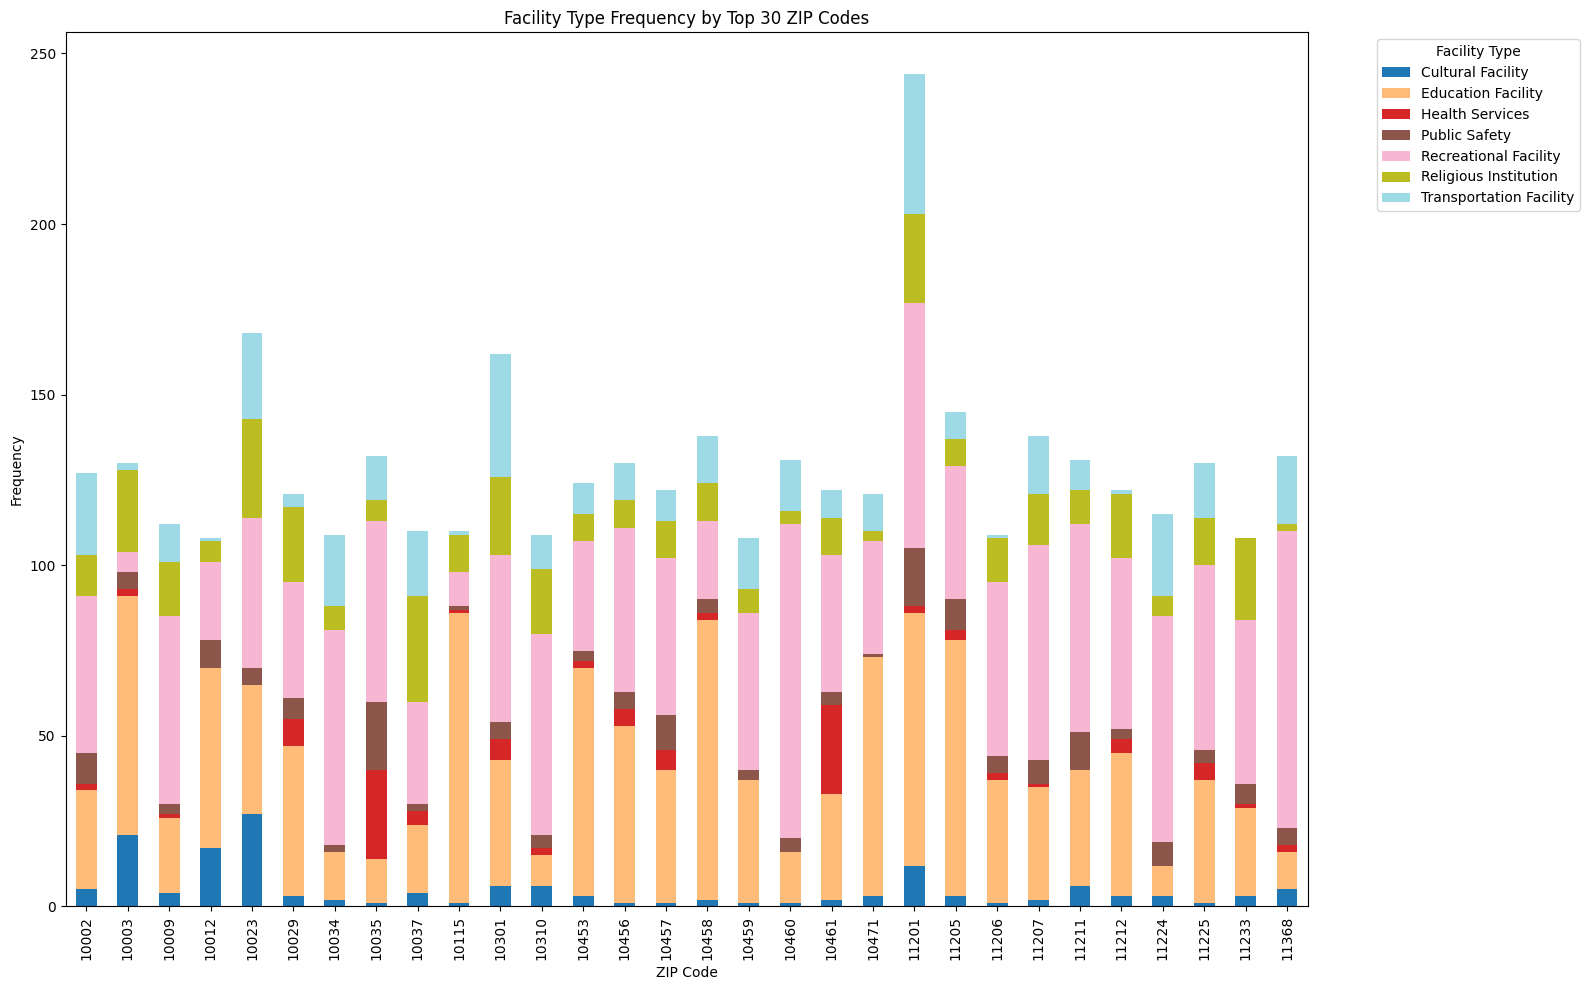

In [54]:
grouped_data = pd.read_csv('cleaned_amenities.csv')

# Aggregate 
aggregated_data = grouped_data.groupby(['ZIP_CODE', 'FACILITY_TYPE'])['COUNT'].sum().reset_index()

# Filter
top_zip_codes = aggregated_data.groupby('ZIP_CODE')['COUNT'].sum().nlargest(30).index
top_aggregated_data = aggregated_data[aggregated_data['ZIP_CODE'].isin(top_zip_codes)]

# Pivot 
pivot_data = top_aggregated_data.pivot(index='ZIP_CODE', columns='FACILITY_TYPE', values='COUNT').fillna(0)

# Plot 
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='tab20', figsize=(16, 10))

plt.title('Facility Type Frequency by Top 30 ZIP Codes')
plt.xlabel('ZIP Code')
plt.ylabel('Frequency')
plt.legend(title='Facility Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [70]:
facility_data = pd.read_csv('cleaned_amenities.csv')
zipcode_data = pd.read_csv('us_zip_codes')

# Man dist
def manhattan_distance(lat1, lon1, lat2, lon2):
    return np.abs(lat1 - lat2) + np.abs(lon1 - lon2)

# Convert the data to NumPy arrays 
facility_lats = facility_data['LAT'].values
facility_lngs = facility_data['LNG'].values
zipcode_lats = zipcode_data['LAT'].values
zipcode_lngs = zipcode_data['LNG'].values

# Calculate distances in a vectorized manner
distances = np.zeros(len(facility_data))

for i in range(len(facility_data)):
    distances[i] = np.min(manhattan_distance(facility_lats[i], facility_lngs[i], zipcode_lats, zipcode_lngs))

# Convert distances 
distances_km = distances * 111  

# Add to DF
facility_data['DISTANCE_TO_FACILITY'] = distances_km

facility_data

,BOROUGH,NAME,FACILITY_TYPE,FACILITY_DESC,ZIP_CODE,LNG,LAT,COUNT,DISTANCE_TO_FACILITY
0,Bronx,138 STREET COMMUNITY GARDEN,Recreational Facility,Garden,10454,-73.915563,40.805709,1,0.137898
1,Bronx,145,Transportation Facility,Bridge,10451,-73.932365,40.819508,1,0.915971
2,Bronx,145 ST BRIDGE PED AND BIKE,Transportation Facility,Bridge,10451,-73.932129,40.819480,1,0.892946
3,Bronx,174 ST,Transportation Facility,Bridge,10460,-73.881176,40.835074,1,0.920130
4,Bronx,174 ST NORTH PED BR OVER I-895,Transportation Facility,Bridge,10460,-73.881685,40.835354,1,0.945489
...,...,...,...,...,...,...,...,...,...
12818,Staten Island,WOODROW METHODIST CHURCH COMPLEX,Religious Institution,Church,10312,-74.201102,40.543374,1,2.499934
12819,Staten Island,WWII VETERANS WAR MEMORIAL ICE SKATING RINK,Recreational Facility,Sports,10304,-74.107607,40.615560,1,2.371526
12820,Staten Island,YESHIVA OF STATEN ISLAND,Education Facility,Private/Parochial K-12 all grades,10309,-74.214403,40.527560,1,1.025604
12821,Staten Island,YOUNG ISRAEL OF STATEN ISLAND,Religious Institution,Synagogue,10314,-74.140036,40.602510,1,3.214461


In [71]:
# Save 
facility_data.to_csv('cleaned_amenities_with_distances.csv', index=False)

<Figure size 1400x800 with 0 Axes>

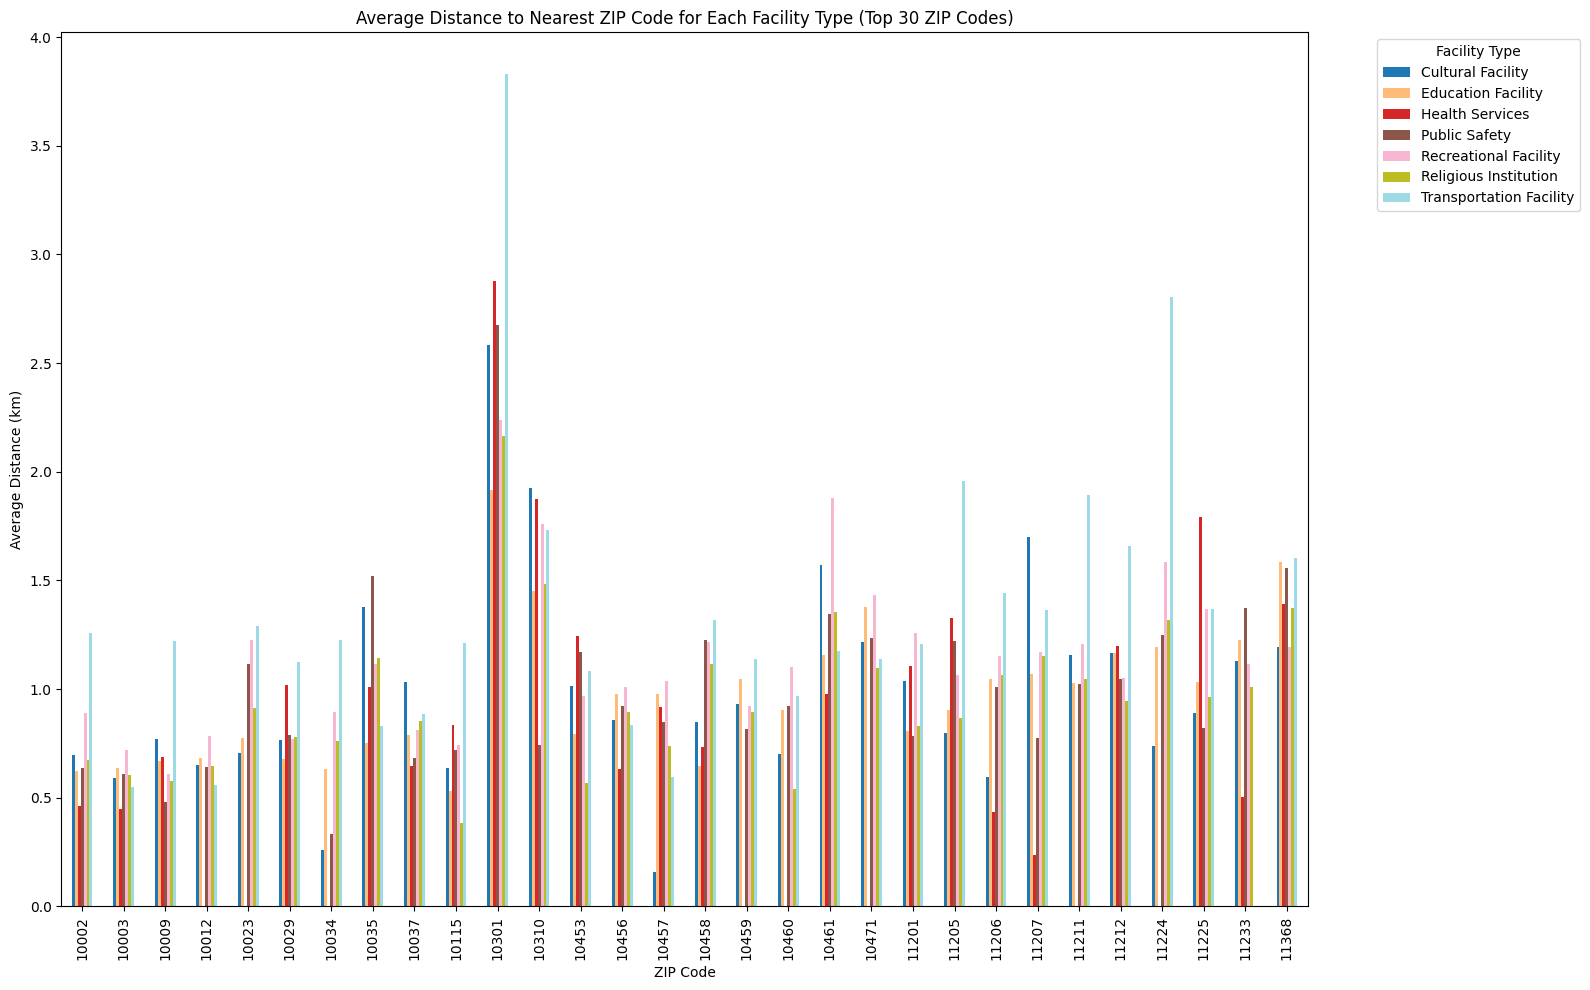

In [62]:
facility_data = pd.read_csv('cleaned_amenities_with_distances.csv')

# Calculate the average distance for each facility type by ZIP_CODE
average_distances = facility_data.groupby(['ZIP_CODE', 'FACILITY_TYPE'])['DISTANCE_TO_FACILITY'].mean().reset_index()

top_zip_codes = facility_data['ZIP_CODE'].value_counts().nlargest(30).index

# Filter
top_average_distances = average_distances[average_distances['ZIP_CODE'].isin(top_zip_codes)]

# Pivot the data 
pivot_data = top_average_distances.pivot(index='ZIP_CODE', columns='FACILITY_TYPE', values='DISTANCE_TO_FACILITY').fillna(0)

# Plot 
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', colormap='tab20', figsize=(16, 10))

plt.title('Average Distance to Nearest ZIP Code for Each Facility Type (Top 30 ZIP Codes)')
plt.xlabel('ZIP Code')
plt.ylabel('Average Distance (km)')
plt.legend(title='Facility Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Save to json

In [72]:
# Load
grouped_data = pd.read_csv('cleaned_amenities_with_distances.csv')

# Convert to json
json_path = 'cleaned_amenities_with_distances.json'
grouped_data.to_json(json_path, orient='records', lines=True)

In [73]:
import json
json_objects = []

with open('cleaned_amenities_with_distances.json', 'r') as file:
    for line in file:
        # Parse 
        json_objects.append(json.loads(line.strip()))

with open('cleaned_amenities_data2.json', 'w') as file:
    json.dump(json_objects, file, indent=4)

## Data for Modelling

In [3]:
# Load
grouped_data = pd.read_csv('cleaned_amenities_with_distances.csv')

In [4]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BOROUGH               12823 non-null  object 
 1   NAME                  12823 non-null  object 
 2   FACILITY_TYPE         12823 non-null  object 
 3   FACILITY_DESC         12823 non-null  object 
 4   ZIP_CODE              12823 non-null  int64  
 5   LNG                   12823 non-null  float64
 6   LAT                   12823 non-null  float64
 7   COUNT                 12823 non-null  int64  
 8   DISTANCE_TO_FACILITY  12823 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 901.7+ KB


In [5]:
# Drop 
grouped_data.drop(columns=['NAME', 'BOROUGH', 'FACILITY_DESC', 'LNG', 'LAT'], inplace=True)

In [6]:
grouped_data

,FACILITY_TYPE,ZIP_CODE,COUNT,DISTANCE_TO_FACILITY
0,Recreational Facility,10454,1,0.137898
1,Transportation Facility,10451,1,0.915971
2,Transportation Facility,10451,1,0.892946
3,Transportation Facility,10460,1,0.920130
4,Transportation Facility,10460,1,0.945489
...,...,...,...,...
12818,Religious Institution,10312,1,2.499934
12819,Recreational Facility,10304,1,2.371526
12820,Education Facility,10309,1,1.025604
12821,Religious Institution,10314,1,3.214461


In [7]:
import pandas as pd

# One-hot encode 
one_hot_encoded_data = pd.get_dummies(grouped_data, columns=['FACILITY_TYPE'])

# Convert 
for col in one_hot_encoded_data.columns:
    if col.startswith('FACILITY_TYPE_'):
        one_hot_encoded_data[col] = one_hot_encoded_data[col].astype(int)

# Rename 
one_hot_encoded_data.columns = one_hot_encoded_data.columns.str.replace('FACILITY_TYPE_', '')

# Set 
pd.set_option('display.precision', 8)

# Display 
one_hot_encoded_data

,ZIP_CODE,COUNT,DISTANCE_TO_FACILITY,Cultural Facility,Education Facility,Health Services,Public Safety,Recreational Facility,Religious Institution,Transportation Facility
0,10454,1,0.13789771,0,0,0,0,1,0,0
1,10451,1,0.91597147,0,0,0,0,0,0,1
2,10451,1,0.89294565,0,0,0,0,0,0,1
3,10460,1,0.92012973,0,0,0,0,0,0,1
4,10460,1,0.94548941,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
12818,10312,1,2.49993401,0,0,0,0,0,1,0
12819,10304,1,2.37152631,0,0,0,0,1,0,0
12820,10309,1,1.02560389,0,1,0,0,0,0,0
12821,10314,1,3.21446094,0,0,0,0,0,1,0


In [8]:
# Rename 
one_hot_encoded_data.columns = [
    'zipcode',
    'count',
    'distance_to_facility',
    'cultural_facility',
    'education_facility',
    'health_services',
    'public_safety',
    'recreational_facility',
    'religious_institution',
    'transportation_facility'
]

In [9]:
# Convert 
binary_columns = [
    'cultural_facility',
    'education_facility',
    'health_services',
    'public_safety',
    'recreational_facility',
    'religious_institution',
    'transportation_facility'
]
one_hot_encoded_data[binary_columns] = one_hot_encoded_data[binary_columns].astype(int)

In [10]:

# Ensure 
one_hot_encoded_data['zipcode'] = one_hot_encoded_data['zipcode'].astype(str)

In [11]:

# Convert 
one_hot_encoded_data['distance_to_facility'] = one_hot_encoded_data['distance_to_facility'].astype(float)

In [16]:
one_hot_encoded_data.to_csv('amenities_model.csv', index=False)
